In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import pi

def exp_format(x, pos=None):
    names = {1: 'Delay',
            2: 'Delay PD',
            3: 'No delay'}
    return names[x]

In [4]:
conn = sqlite3.connect("data.db")
act = pd.read_sql_query("select rowid, * from actors where valid=1;", conn)

## Performance

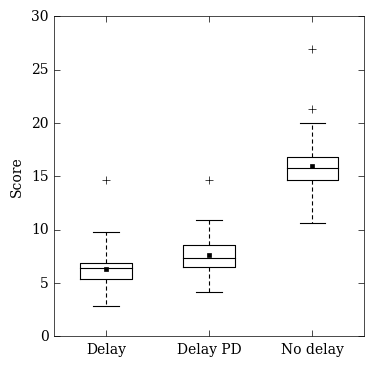

In [15]:
filename = 'performance_norm'
plt.style.use('classic')
plt.style.use('thesis.mplstyle')

hits = np.array(act[['tothitsexp0', 'tothitsexp1', 'tothitsexp2', 'tothits']]).astype(float)
norm = np.zeros((hits.shape[0],3))
avg = hits.mean(axis=0)
for i, row in enumerate(hits):
    norm[i,0] = row[0]/row[3]*avg[3]
    norm[i,1] = row[1]/row[3]*avg[3]
    norm[i,2] = row[2]/row[3]*avg[3]

fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(norm, whis=2, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Score')
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

#### Table values

In [98]:
means = norm.mean(axis=0)

x = np.reshape(np.reciprocal(means), (3,1))
y = np.reshape(means, (1,3))
change = np.dot(x,y)-1
change = change.T

d = {'experiment':[exp_format(i+1) for i in range(3)],
    'mean':means,
    'std':norm.std(axis=0),
    'max':norm.max(axis=0),
    'min':norm.min(axis=0),
     'median':np.median(norm, axis=0),
    'diff_delay':change[...,0],
    'diff_pd':change[...,1],
    'diff_normal':change[...,2],
    }
table = pd.DataFrame(data=d)
table

,diff_delay,diff_normal,diff_pd,experiment,max,mean,median,min,std
0,0.000000,-0.605238,-0.168667,Delay,14.684211,6.320525,6.384439,2.842105,1.751276
1,0.202887,-0.525146,0.000000,Delay PD,14.684211,7.602880,7.342105,4.195489,1.706740
2,1.533175,0.000000,1.105912,No delay,26.921053,16.010994,15.813765,10.679426,2.531100


In [99]:
print('Mean differences for score compared to all experiments\n{}'.format('-'*57))
print('{:9} {:>15} {:>15} {:>15}'.format('', *(exp_format(i+1) for i in range(3))))
for idx, row in table.iterrows():
    print('{:9} {:>14.2f}% {:>14.2f}% {:>14.2f}%'.format(exp_format(idx+1), 
                                           row['diff_delay']*100, 
                                           row['diff_pd']*100, 
                                           row['diff_normal']*100))

Mean differences for score compared to all experiments
---------------------------------------------------------
                    Delay        Delay PD        No delay
Delay               0.00%         -16.87%         -60.52%
Delay PD           20.29%           0.00%         -52.51%
No delay          153.32%         110.59%           0.00%


### Effect size

In [101]:
table.to_latex()

'\\begin{tabular}{lrrrlrrrrr}\n\\toprule\n{} &  diff\\_delay &  diff\\_normal &   diff\\_pd & experiment &        max &       mean &     median &        min &       std \\\\\n\\midrule\n0 &    0.000000 &    -0.605238 & -0.168667 &      Delay &  14.684211 &   6.320525 &   6.384439 &   2.842105 &  1.751276 \\\\\n1 &    0.202887 &    -0.525146 &  0.000000 &   Delay PD &  14.684211 &   7.602880 &   7.342105 &   4.195489 &  1.706740 \\\\\n2 &    1.533175 &     0.000000 &  1.105912 &   No delay &  26.921053 &  16.010994 &  15.813765 &  10.679426 &  2.531100 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Load index

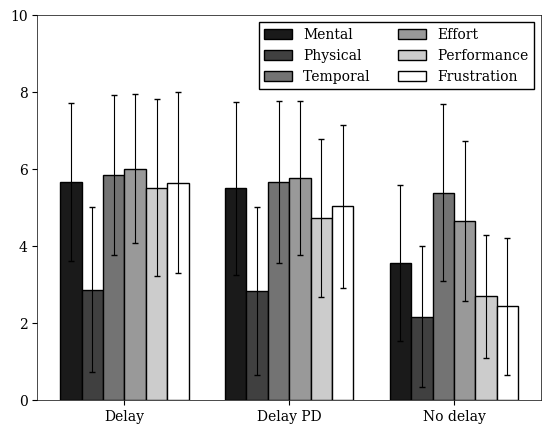

In [18]:
filename = 'nasa_tlx_bar'
plt.style.use('default')
plt.style.use('thesis.mplstyle')

n_partic = pd.read_sql_query("select rowid from actors where valid=1 ;", conn).size
fig1, ax1 = plt.subplots(figsize=(6.5,5))

bar_width= 0.13

for idx, metric in enumerate(['Mental', 'Physical', 'Temporal', 'Effort', 'Performance', 'Frustration']):
    data = np.zeros([n_partic,3])
    for exp in range(3):
        load = pd.read_sql_query("select {} from survey where valid=1 and experiment={};"
                                 .format(metric, exp), conn)
        data[...,exp] = np.reshape(np.array(load),(57,))
    if metric == 'Performance':
        data = np.ones_like(data)*10-data
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    x_pos = np.arange(3)+1 - bar_width*3 +idx*bar_width+bar_width/2
    
    ax1.bar(x_pos, mean, bar_width, yerr=std, label=metric, 
            edgecolor='k', 
            linewidth=1,
           capsize=2,
           error_kw={'linewidth':0.8})


ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
ax1.set_xticks(np.arange(3)+1)
plt.ylim(0,10)
plt.legend(ncol=2)
plt.show()
# fig1.savefig('../img/{}.png'.format(filename), bbox_inches='tight')